## Variational Zero-inflated Gaussian Processes in GPFlow

In [26]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import gpflow as gpf
import numpy as np
gpf.config.set_default_float(np.float32)

gpf.config.set_default_jitter(tf.cast(1e-6, dtype=gpf.default_float()))
from onoffgpf import OnOffSVGP, OnOffLikelihood
from onoffgpf.PlotOnOff1D import PlotOnOff1D

from gpflow.ci_utils import ci_niter

import gpflow

import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow_probability as tfp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


** Load simulated dataset **

In [27]:
matdata = sio.loadmat('data/toydata.mat')
Xtrain = matdata['x'].astype(gpf.default_float())
Ytrain = matdata['y'].astype(gpf.default_float())

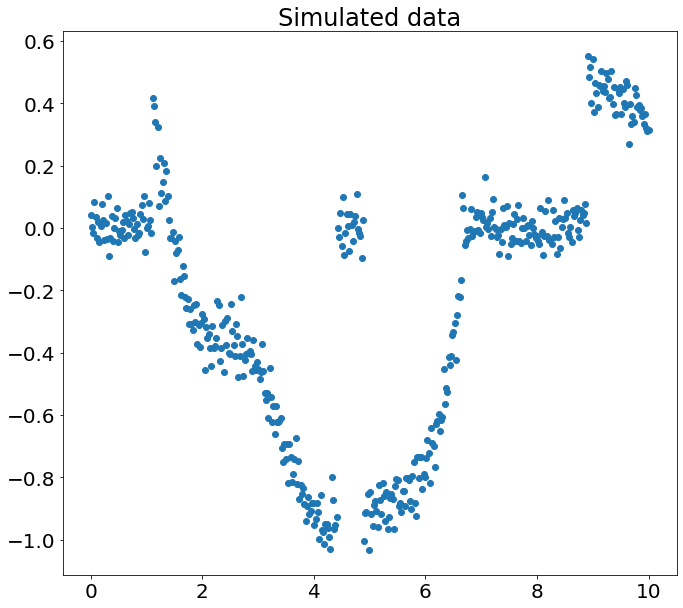

In [28]:
plt.scatter(Xtrain,Ytrain)
plt.title("Simulated data")
plt.show()

**Train specifications & variable initializations**

In [29]:
Xtrain[np.random.choice(range(len(Xtrain)), 10)]

array([[6.1692653],
       [4.2761693],
       [3.2293987],
       [1.4476615],
       [3.0957685],
       [3.0066814],
       [0.7572383],
       [4.788419 ],
       [2.9398663],
       [8.641425 ]], dtype=float32)

In [30]:
num_iterations = 1000000
num_inducing   = 10

# initalize kernel parameters
kf = gpf.kernels.RBF(variance=1, lengthscales=2)
#kf.lengthscales = 2.
#kf.variance = 1.

kg = gpf.kernels.RBF(variance=5, lengthscales=2)
#kg.lengthscales = 2.
#kg.variance = 5.

# initialise equally spaced inducing point locations
Zf = []
Zg = []

#for i in range(10):
#    Zf.append(np.delete(np.linspace(min(Xtrain)+max(Xtrain)*.3*i/9,max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1))
#    Zg.append(np.delete(np.linspace(min(Xtrain)+max(Xtrain)*.3*i/9,max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1))


for i in range(10):
    random_points = Xtrain[np.random.choice(range(len(Xtrain)), 9)]
    Zf.append(np.flip(np.sort(random_points)))
    Zg.append(np.flip(np.sort(random_points)))

** Model build and training **

In [31]:
# model definition
models = []
for i in range(10):
    m = OnOffSVGP(Xtrain, Ytrain
                  ,kernf=kf,kerng=kg
                  ,likelihood = OnOffLikelihood()
                  ,Zf = Zf[i],Zg = Zg[i]
                 )

    # fix the model noise term
    m.likelihood.variance.assign(0.01)
    from gpflow import set_trainable
    set_trainable(m.likelihood.variance, True)
    models.append(m)

minibatch_size = 100

N=len(Xtrain)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(Xtrain,),
                                                    tf.convert_to_tensor(Ytrain,)),)#.repeat().shuffle(N)

train_iter = iter(train_dataset)#batch(minibatch_size))


In [32]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.005)#gpflow.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

In [36]:
maxiter = ci_niter(100000)
logs = []
for i in range(10):
    print(i)
    def run_adam(model, iterations):
        """
        Utility function running the Adam optimizer

        :param model: GPflow model
        :param interations: number of iterations
        """
        # Create an Adam Optimizer action
        logf = []
        train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
        training_loss = model.training_loss_closure(compile=True)
        optimizer = tf.optimizers.Adam(learning_rate=0.005)#gpflow.optimizers.Adam(learning_rate=0.01)

        @tf.function
        def optimization_step():
            optimizer.minimize(training_loss, model.trainable_variables)

        for step in range(iterations):
            optimization_step()
            if step % 10 == 0:
                elbo = -training_loss().numpy()
                logf.append(elbo)
        return logf
    logf = run_adam(models[i], maxiter)
    logs.append(logf)

0
1
2
3
4
5
6
7
8
9


In [9]:
len(logf)

10000

In [10]:
#m.optimize(maxiter = num_iterations) #,method= tf.train.AdamOptimizer(learning_rate = 0.01)
m.compute_log_likelihood()

AttributeError: 'OnOffSVGP' object has no attribute 'compute_log_likelihood'

** Mode fit visualization **

In [ ]:
# model plot
PlotOnOff1D(models[1])

In [ ]:
Xtrain.shape

In [ ]:
from gpflow.config import default_jitter

In [ ]:
default_jitter()

In [ ]:
f.eye(m.num_inducing_f, dtype=float_type) * default_jitter()

In [ ]:
kf.K(Xtrain)

In [ ]:
default_float

In [ ]:
gpf.default_float()

In [ ]:
m.X.dtype

In [ ]:
m.Zf.numpy()

In [ ]:
m.likelihood.variance

In [ ]:
m.kernf.K(m.Xtrain)

In [ ]:
dir(m.kernf)

In [ ]:
import scipy
optimizer = tf.optimizers.Adam()
optimizer.minimize(
    m.training_loss_closure(),
    m.trainable_variables,
)

In [ ]:
m.training_loss_closure()

In [ ]:
m.trainable_variables

In [ ]:
m.training_loss()

In [ ]:
m

In [ ]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(
    m.training_loss_closure(compile=True),
    m.trainable_variables,
    options=dict(maxiter=(80000),),tol=1e-16
)

In [ ]:
m.likelihood

In [ ]:
dir(m)

In [ ]:
m.likelihood

In [ ]:
m.Zf

In [ ]:
m.Zg

In [ ]:
Zf

In [ ]:
dir(m.kerng)

In [ ]:
m.kerng.variance

In [ ]:
m.kernf.lengthscales

In [ ]:
m.kerng

In [ ]:

from gpflow.utilities import print_summary

In [ ]:
print_summary(kg)

In [ ]:
m.log_posterior_density

In [ ]:
plt.plot(range(len(logf)), logf)
plt.ylim(-200,600)

(-200.0, 600.0)

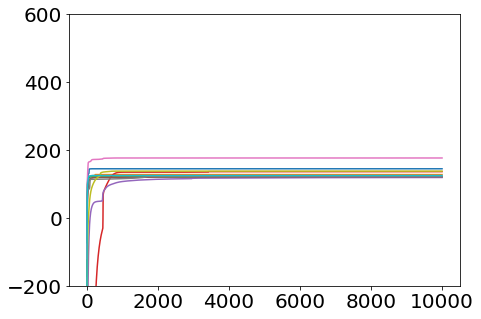

In [38]:
plt.figure(figsize=(7,5))
for i in range(10):
    plt.plot(range(len(logs[i])), logs[i])
plt.ylim(-200,600)



In [29]:
logs[2]

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [ ]:
models[3]

In [ ]:
models[0].trainable_variables

In [ ]:
Zf[0].shape

In [ ]:
Zf[0]

In [ ]:
Zg[0]

In [ ]:
train_dataset.numpy

In [30]:
logs[2][-1]

nan

In [22]:
logs[0]

[-40850296.0,
 -23891776.0,
 -16144235.0,
 -8316679.5,
 -4540242.0,
 -3129511.8,
 -2501434.8,
 -2172388.5,
 -1712907.0,
 -1382694.9,
 -1282322.5,
 -1085117.8,
 -1629959.0,
 -968924.9,
 -1147661.8,
 -981690.75,
 -752198.1,
 -1387635.8,
 -1313097.5,
 -1091603.5,
 -804336.7,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 